In [167]:
#!/usr/bin/env python3

import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from collections import Counter
import sys
import matplotlib.pyplot as plt
import re
from statistics import mean 
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading fake and real news files

The following cell is to be used to load the files in Google colab which we used as the computing time was way faster.

In [167]:
# Get empty news indexes
empty_fake_index = [index for index,text in enumerate(fake_df.text.values) if str(text).strip() == '']

# Checking some of those rows 
fake_df.iloc[empty_fake_index].tail()

In [168]:
true_df = pd.read_csv('True.csv')
fake_df = pd.read_csv('Fake.csv')

# Exploring data

Let's first clean a bit the data to make sure everything is coherent

In [169]:
def cleaning_data(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]','',text) # remove punctuation
    text = re.sub('(\s+)', ' ', text) # removing extra whitespaces
    text = re.sub('\[.*?\]', '', text) # remove square brackets
    text = re.sub('\w*\d\w*', '', text) # remove words containing numbers
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text) # remove http
    text = re.sub('\n', ' ', text) # remove new lines
    text = re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', text) # remove single letters
    return text

In [170]:
true_df['text'] = true_df.text.apply(lambda text : cleaning_data(text))
fake_df['text'] = fake_df.text.apply(lambda text : cleaning_data(text))
true_df['title'] = true_df.text.apply(lambda text : cleaning_data(text))
fake_df['title'] = fake_df.text.apply(lambda text : cleaning_data(text))

First let's see how many data we have in our datasets

In [171]:
print("There are {} observations and {} features in the fake dataset.".format(fake_df.shape[0],fake_df.shape[1]))

There are 23481 observations and 4 features in the fake dataset.


In [172]:
print("There are {} observations and {} features in the true dataset.".format(true_df.shape[0],true_df.shape[1]))

There are 21417 observations and 4 features in the true dataset.


The datasets are rather balanced in term of rows, now let's plot both wordclouds to understand the data a bit better

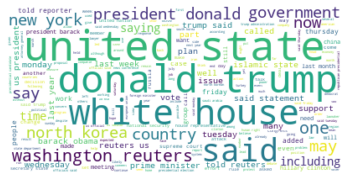

In [173]:
true_text = " ".join(review for review in true_df.text)
stopwords = set(STOPWORDS)


# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(true_text)



# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

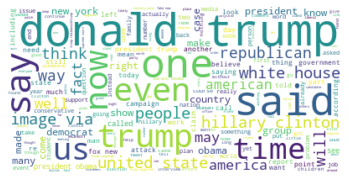

In [174]:
fake_text = " ".join(review for review in fake_df.text)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(fake_text)


# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We saw that the datasets have roughly the same amount of rows, but let's try to see if the data is biaised. To do so, we will try to see if there are some words that are extremely used in one data set compared to the other

In [175]:
true_text_list = true_text.split()
frequency_true = Counter(true_text_list)

fake_text_list = fake_text.split()
frequency_fake = Counter(fake_text_list)




frequency_true.subtract(frequency_fake)
occurence_diff = dict(frequency_true)
occurence_unbalance = { k: v for k, v in occurence_diff.items() if float(v) >= 10000 or float(v) <= -10000}
print({k: v for k, v in sorted(occurence_unbalance.items(), reverse = True, key=lambda item: item[1])})

{'said': 68031, 'reuters': 28041, 'on': 27209, 'us': 19139, 'in': 16417, 'its': 14242, 'trumps': 11430, 'clinton': -10097, 'one': -10187, 're': -10191, 'when': -10624, 'via': -10655, 'obama': -10699, 'hillary': -10780, 'people': -10825, 'can': -11429, 'our': -12157, 'for': -12177, 'out': -12220, 'so': -12886, 'like': -13080, 'their': -13375, 'she': -14058, 'be': -14207, 'who': -14681, 'all': -15162, 'her': -15211, 'about': -15348, 'just': -15665, 'what': -16224, 'we': -17999, 'was': -19759, 'his': -19990, 'are': -20115, 'they': -23699, 'he': -23986, 'of': -30762, 'trump': -30822, 'it': -31624, 'this': -33776, 'you': -34487, 'and': -42654, 'to': -44422, 'the': -44458, 'is': -55221, 'that': -62837}


We can see that some words are making the dataset extremely unbalanced such as 'trump' or 'said'.

This is definitely something to keep in mind when doing the preprocessing

# Preparing the datasets

In [176]:
# Adding class Information
true_df["class"] = 1
fake_df["class"] = 0
print(true_df.tail())


                                                   title  ... class
21412  brussels reuters nato allies on tuesday welcom...  ...     1
21413  london reuters lexisnexis provider of legal re...  ...     1
21414  minsk reuters in the shadow of disused soviete...  ...     1
21415  moscow reuters vatican secretary of state card...  ...     1
21416  jakarta reuters indonesia will buy sukhoi figh...  ...     1

[5 rows x 5 columns]


Since there might be some empty text in those datasets (maybe the news is only made of a video ?)

In [177]:
# Get empty news indexes
empty_fake_index = [index for index,text in enumerate(fake_df.text.values) if str(text).strip() == '']

# Checking some of those rows 
fake_df.iloc[empty_fake_index].tail()

,title,text,subject,date,class
21827,,,left-news,"Apr 25, 2015",0
21857,,,left-news,"Apr 14, 2015",0
21869,,,left-news,https://fedup.wpengine.com/wp-content/uploads/...,0
21870,,,left-news,https://fedup.wpengine.com/wp-content/uploads/...,0
21873,,,left-news,"Apr 12, 2015",0


In [ ]:
# Get empty news indexes
empty_true_index = [index for index,text in enumerate(true_df.text.values) if str(text).strip() == '']

# Checking some of those rows 
true_df.iloc[empty_true_index].tail()

To solve this and since it seems kinda pointless to separate them, we are merging the title and the text of the news

In [178]:
fake_df['text'] = fake_df['title'] + " " + fake_df['text']
true_df['text'] = true_df['title'] + " " + true_df['text']

fake_df = fake_df.drop(['title'], axis = 1)
true_df = true_df.drop(['title'], axis = 1)

We think the subject could have been an interesting addition but since they are different across both datasets they might cause an overfitting if the model is able to predict a fake news solely by having the subject be "News" for exemple. We are also dropping the date to focus more on the text classification aspect.

In [179]:
fake_df = fake_df.drop(['subject','date'], axis = 1)
true_df = true_df.drop(['subject', 'date'], axis = 1)

There might be some duplicated news so we are dropping them

In [180]:
true_df = true_df.drop_duplicates(keep=False)
fake_df = fake_df.drop_duplicates(keep=False)

Let's check how it impacted the balance between the two sets

In [181]:
print("There are {} observations and {} features in the fake dataset.".format(fake_df.shape[0],fake_df.shape[1]))
print("There are {} observations and {} features in the true dataset.".format(true_df.shape[0],true_df.shape[1]))

There are 12507 observations and 2 features in the fake dataset.
There are 20936 observations and 2 features in the true dataset.


Combining both datasets

In [182]:
data = pd.concat([true_df, fake_df], ignore_index=True, sort=False)
data.tail(15)

,text,class
33428,update robert barnes the white homeless man wh...,0
33429,boy suffered gunshot wound to the leg wednesda...,0
33430,only one journalist has made it his mission to...,0
33431,customer at burger king is hoping to get refun...,0
33432,the moral decay continues the kapiolani medica...,0
33433,about of the emails got were of support there...,0
33434,patriots removed the the chinese flag between ...,0
33435,the michael brown and eric garner cases have o...,0
33436,this is sad commentary on generation who has t...,0
33437,yeah that whole taking up arms thing seems to ...,0


# Preprocessing text
   ## First preprocessing
   For this first processing we want to try doing a really light preprocessing, only removing basic stop words and stemming the text.
   

Stemming

In [183]:
ps = nltk.stem.PorterStemmer() 
def stemming(text):
  
    tokens = nltk.word_tokenize(text)
    text = [ps.stem(w) for w in tokens]
    return " ".join(text)

Removing stopwords

In [184]:
def remove_stopwords(text):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    stop_words.update(["u", "ur","us", "re", "ill", "ull", "ha", "ok", "cant", "dont", "im", "weve", "doesnt", "didnt", "dont", "wa", "couldnt", "couldve", "ive", "isnt", "theres", "wasnt", "wouldnt", "a"])
    tokens = nltk.word_tokenize(text)
    filtered_sentence = []
    for w in tokens:
        if w not in stop_words:
            filtered_sentence.append(w)

    return " ".join(filtered_sentence)


In [185]:
preprocessing_data_1 = data.copy()
preprocessing_data_1['text'] = preprocessing_data_1.text.apply(lambda text : remove_stopwords(text))
preprocessing_data_1['text'] = preprocessing_data_1.text.apply(lambda text : stemming(text))
preprocessing_data_1.tail()

,text,class
33438,centuri wire say world stage men women mere pl...,0
33439,randi johnson centuri wireth major mainstream ...,0
33440,tune altern current radio network acr anoth li...,0
33441,centuri wire say new front open long battl ame...,0
33442,centuri wire say far away guess want run presi...,0


## Second preprocessing
For this second preprocessing, we want to use what we saw from the explore part. For exemple, we believe that words such as "said", "reuters", "trump" might be enough to guess if a news is a fake news or not simply because of the unbalance we saw in the datasets. We also added lemmatization.

Lemmatization

In [186]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatization(text):
    tokens = nltk.word_tokenize(text)
    text = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(text)

In [187]:
def remove_stopwords_preprocess2(text):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    stop_words.update(["re", "reuters", "trump", "said", "us","u", "ur", "ill", "ull", "ha", "ok", "cant", "dont", "im", "weve", "doesnt", "didnt", "dont", "wa", "couldnt", "couldve", "ive", "isnt", "theres", "wasnt", "wouldnt", "a"])
    tokens = nltk.word_tokenize(text)
    filtered_sentence = []
    for w in tokens:
        if w not in stop_words:
            filtered_sentence.append(w)

    return " ".join(filtered_sentence)


In [188]:

preprocessing_data_2 = data.copy()
preprocessing_data_2['text'] = preprocessing_data_2.text.apply(lambda text : lemmatization(text))
preprocessing_data_2['text'] = preprocessing_data_2.text.apply(lambda text : remove_stopwords_preprocess2(text))
preprocessing_data_2.tail()

,text,class
33438,century wire say world stage men woman merely ...,0
33439,randy johnson century wirethe majority mainstr...,0
33440,tune alternate current radio network acr anoth...,0
33441,century wire say new front opened long battle ...,0
33442,century wire say far away guess want run presi...,0


# Models
We decided to try two kind of supervised algorithms : Naïve Bayes and Logistic regression.

## Naïve Bayes with first preprocessing

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2502
           1       0.97      0.96      0.97      4187

    accuracy                           0.96      6689
   macro avg       0.95      0.96      0.96      6689
weighted avg       0.96      0.96      0.96      6689

Mean of the cross validation scores : 0.9462957906895245

Confusion matrix :



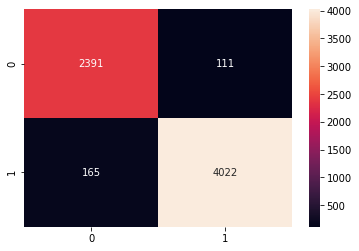

In [189]:
cv = CountVectorizer()
X =  cv.fit_transform(preprocessing_data_1['text'])
y = preprocessing_data_1['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

NB = MultinomialNB()
NB.fit(X_train,y_train)
y_pred = NB.predict(X_test)
print(classification_report(y_test, y_pred))

kfold = StratifiedKFold(n_splits=10)
cv_scores = cross_val_score(NB, X, y, scoring='accuracy', cv=kfold, n_jobs=4)
print("Mean of the cross validation scores : {}".format(mean(cv_scores)))


cfm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix :\n")
sns.heatmap(cfm, annot=True, fmt='d')

## Naive Bayes with second preprocessing

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2502
           1       0.97      0.95      0.96      4187

    accuracy                           0.95      6689
   macro avg       0.95      0.95      0.95      6689
weighted avg       0.95      0.95      0.95      6689

Mean of the cross validation scores : 0.9387906323084515

Confusion matrix :



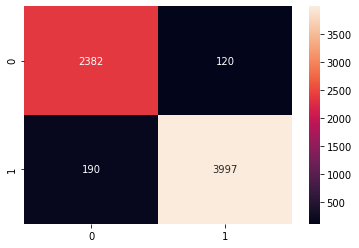

In [190]:
cv = CountVectorizer()
X =  cv.fit_transform(preprocessing_data_2['text'])
y = preprocessing_data_2['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

NB = MultinomialNB()
NB.fit(X_train,y_train)
y_pred = NB.predict(X_test)
print(classification_report(y_test, y_pred))

kfold = StratifiedKFold(n_splits=10)
cv_scores = cross_val_score(NB, X, y, scoring='accuracy', cv=kfold, n_jobs=4)
print("Mean of the cross validation scores : {}".format(mean(cv_scores)))


cfm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix :\n")
sns.heatmap(cfm, annot=True, fmt='d')

## Logistic Regression with first preprocessing

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2502
           1       0.98      0.99      0.99      4187

    accuracy                           0.99      6689
   macro avg       0.99      0.98      0.99      6689
weighted avg       0.99      0.99      0.99      6689

Mean of the cross validation scores : 0.9800546591713691

Confusion matrix :



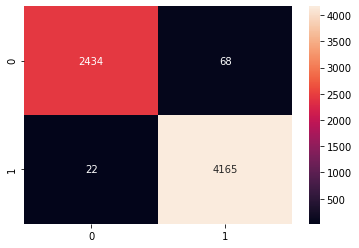

In [191]:
v = TfidfVectorizer()
X = v.fit_transform(preprocessing_data_1['text'])
y = preprocessing_data_1['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)


logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
logisticRegr.predict(X_test[0].reshape(1,-1))
y_pred = logisticRegr.predict(X_test)
print(classification_report(y_test, y_pred))

kfold = StratifiedKFold(n_splits=10)
cv_scores = cross_val_score(logisticRegr, X, y, scoring='accuracy', cv=kfold, n_jobs=4)
print("Mean of the cross validation scores : {}".format(mean(cv_scores)))


cfm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix :\n")
sns.heatmap(cfm, annot=True, fmt='d')

## Logistic Regression with second preprocessing

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2502
           1       0.98      0.99      0.98      4187

    accuracy                           0.98      6689
   macro avg       0.98      0.98      0.98      6689
weighted avg       0.98      0.98      0.98      6689

Mean of the cross validation scores : 0.9701267960463735

Confusion matrix :



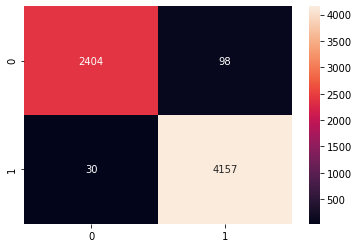

In [192]:
v = TfidfVectorizer()
X = v.fit_transform(preprocessing_data_2['text'])
y = preprocessing_data_2['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)


logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
logisticRegr.predict(X_test[0].reshape(1,-1))
y_pred = logisticRegr.predict(X_test)
print(classification_report(y_test, y_pred))

kfold = StratifiedKFold(n_splits=10)
cv_scores = cross_val_score(logisticRegr, X, y, scoring='accuracy', cv=kfold, n_jobs=4)
print("Mean of the cross validation scores : {}".format(mean(cv_scores)))


cfm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix :\n")
sns.heatmap(cfm, annot=True, fmt='d')

# Conclusion 

We can see a slight drop in accuracy with our second preprocssing. This is probably due to our choice to remove words that were heavily on one side of the dataset such as "said" and "reuters", therefore we see this drop as a positive thing. On the other hand, our work made it quite apparent that this dataset was rather poorly made with some news being wrongfully labeled as fake, a lot of duplicates for the fake news and a clear unbalance between fake and real news.